In [ ]:
# need to restart kernel after this install
!pip install dmba xgboost wordcloud

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import LabelEncoder
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from xgboost.sklearn import XGBClassifier

### Data Understanding & Cleanup

In [12]:
# Create dataframe for the Proto Complaints dataset
proto_df = pd.read_csv('https://storage.googleapis.com/suptech-week-2024-hackathon/sample-data/proto/Complaint_Proto.csv')

# Display the first five records of the data frame
print(proto_df.head(5).T)

                                                                 0  \
Created_at                                                  8/7/18   
UPDATED_AT                                               24/8/2018   
Description            Your request to change your mailing address   
Category 1                                             CREDIT CARD   
Category 2                                             CREDIT CARD   
Category 3                                                  Others   
Complaint Mode                                              E-mail   
Resolution Type                                                NaN   
Consumer Profile Type                                   Individual   
Note                                                           NaN   

                                                                       1  \
Created_at                                                     18/7/2018   
UPDATED_AT                                                     28/8/2018   
D

In [13]:
# Determine dimensions of dataframe
print('Dimensions of dataframe:',proto_df.shape )

Dimensions of dataframe: (12921, 10)


In [14]:
# Check for duplicate records
proto_df.duplicated().sum()

0

In [15]:
#Identify datatypes of the variables
print(proto_df.dtypes)

Created_at               object
UPDATED_AT               object
Description              object
Category 1               object
Category 2               object
Category 3               object
Complaint Mode           object
Resolution Type          object
Consumer Profile Type    object
Note                     object
dtype: object


In [16]:
#List no. of unique & null values for all the variables
column_list = [a for a in proto_df]
# Column Name , Unique Value , Count of Nulls

for col in proto_df.select_dtypes(['object','int']).columns:
    print(col,':',proto_df[col].nunique(),':',proto_df[col].isna().sum())

Created_at : 514 : 0
UPDATED_AT : 421 : 4
Description : 12145 : 0
Category 1 : 11 : 264
Category 2 : 33 : 264
Category 3 : 73 : 265
Complaint Mode : 5 : 0
Resolution Type : 10 : 7616
Consumer Profile Type : 2 : 5
Note : 9 : 12261


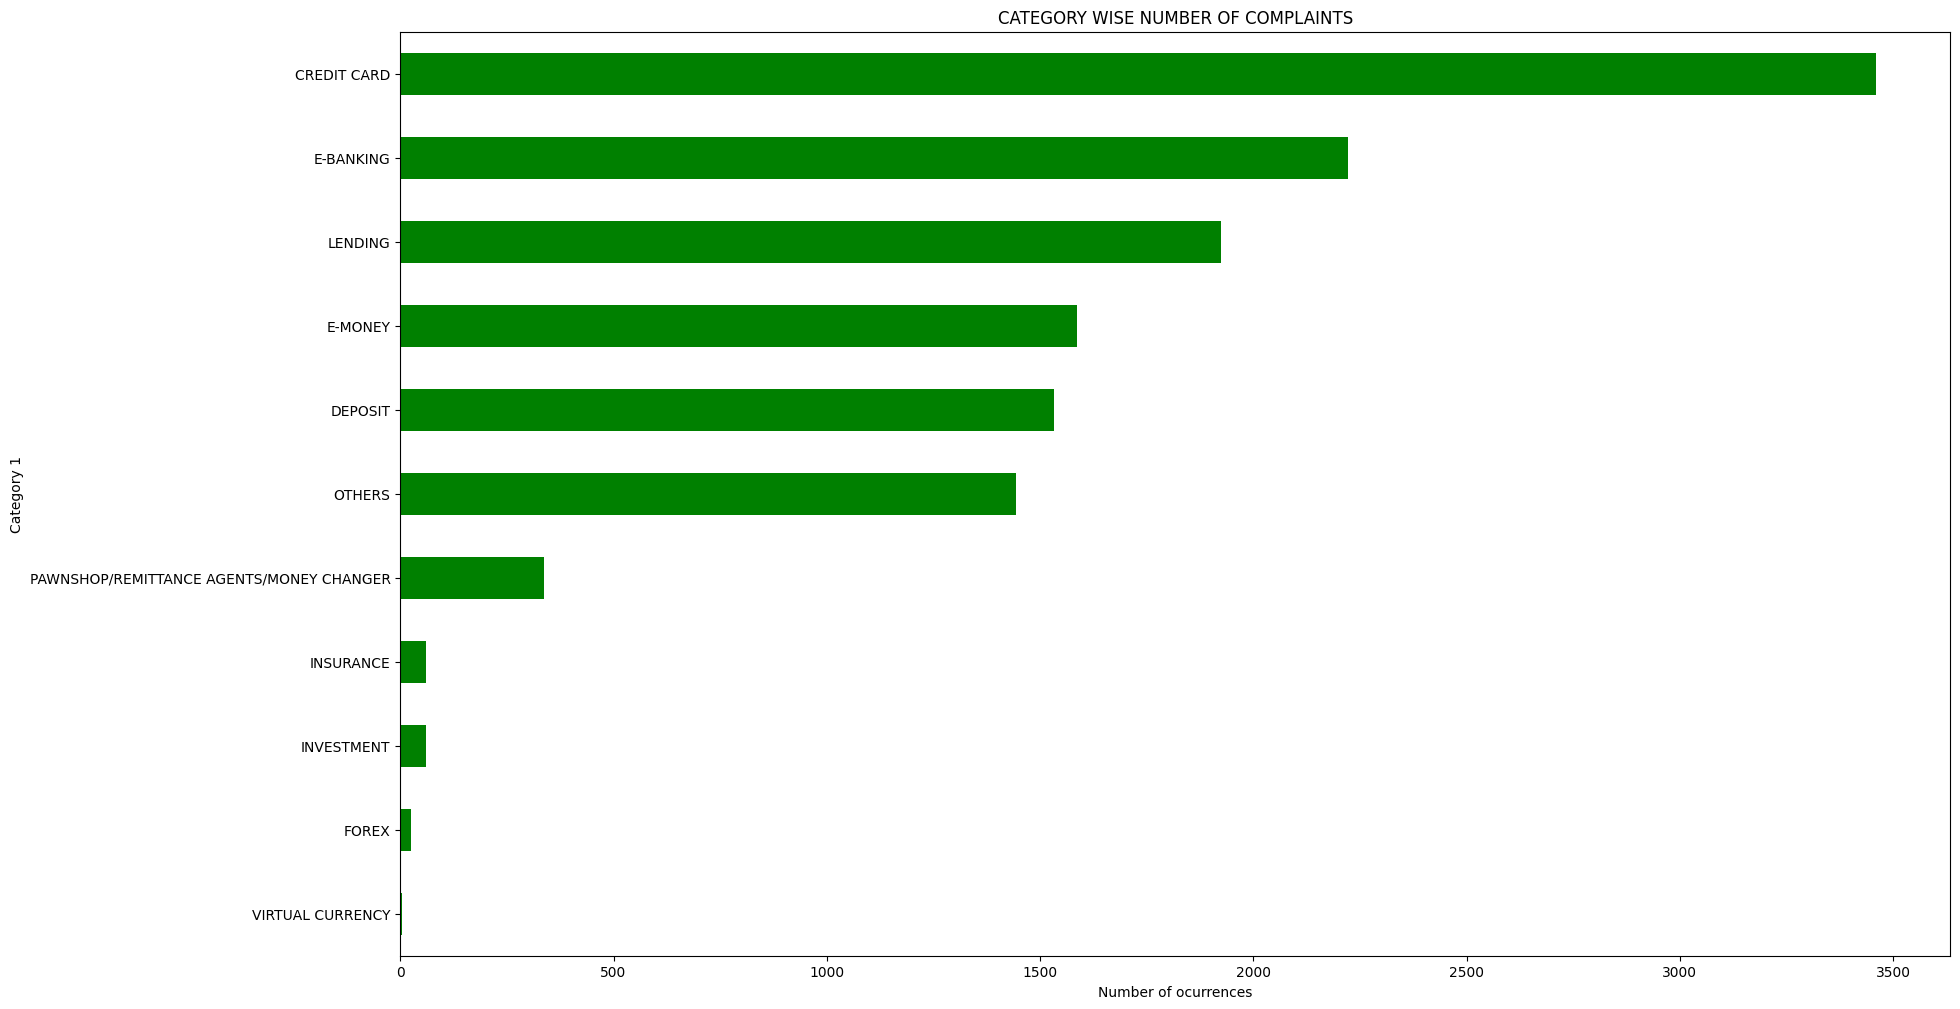

In [20]:
%matplotlib inline

# Product-wise complaints breakup
fig = plt.figure(figsize=(20,12))
proto_df.groupby(['Category 1'])['Description'].count().sort_values().plot.barh(
    ylim=0, color='green', title= 'CATEGORY WISE NUMBER OF COMPLAINTS')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [21]:
# Variable - details
proto_df['Category 1'].value_counts()

Category 1
CREDIT CARD                                 3461
E-BANKING                                   2223
LENDING                                     1925
E-MONEY                                     1586
DEPOSIT                                     1532
OTHERS                                      1444
PAWNSHOP/REMITTANCE AGENTS/MONEY CHANGER     337
INVESTMENT                                    60
INSURANCE                                     60
FOREX                                         25
VIRTUAL CURRENCY                               4
Name: count, dtype: int64

In [22]:
# Variable - details
proto_df['Category 2'].value_counts()

Category 2
CREDIT CARD                                      3461
E-MONEY                                          1586
Others                                           1444
Savings Deposit                                  1136
Internet Banking                                 1009
Personal Loan                                     947
ATM                                               710
Residential/Real Estate Loan                      454
Debit Card                                        392
Auto Loan                                         392
Money Remittance                                  259
Checking Account                                  192
Tracing of Deposit                                 99
Mobile Banking                                     98
Salary Loan                                        85
Pawnbrokering                                      71
Time Deposit                                       65
Business Loan                                      39
Life Insurance   

In [23]:
# Variable - details
X = proto_df['Category 3'].value_counts()
print(X.head(25))

Category 3
Others                         2064
Payment and Settlement         1038
Disputed transactions          1014
Uncredited amount               783
Unfair collection practices     734
Fund transfer                   668
Fees                            534
Charges and Fees                524
Law, Regulation, Policy         392
Withdrawal-related              373
Customer Service                366
Non FCPD Issues                 357
Card Application & Issuance     318
Undispensed withdrawal          314
Scam                            258
Statement of Account            214
Account status                  188
Documentation                   188
Usage                           174
Promos & Rewards                167
Card Cancellation               156
Receiving                       149
Unauthorized withdrawal         141
Unremitted amount               138
Mortgage                        121
Name: count, dtype: int64


In [24]:
proto_df1 = proto_df.copy()

In [25]:
# Drop the columns which are not important for the analysis

proto_df1.drop(['Created_at','UPDATED_AT','Category 2','Category 3', 
          'Complaint Mode','Resolution Type','Consumer Profile Type','Note'],axis=1,inplace=True)

In [26]:
# Dimension of the modified dataset
proto_df1.shape

(12921, 2)

In [27]:
#List no. of null values
proto_df1.isnull().sum()

Description      0
Category 1     264
dtype: int64

In [28]:
# Drop rows with null entries
proto_df1.dropna(inplace=True)

In [29]:
# Clean data dimensions
proto_df1.shape

(12657, 2)

In [30]:
#Clean dataset
proto_df1

,Description,Category 1
0,Your request to change your mailing address,CREDIT CARD
1,unauthorized transactions on a pre-approved cr...,CREDIT CARD
2,Complaint of Mr. XXX regarding his applicatio...,CREDIT CARD
3,Captured ATM card,E-BANKING
4,Complaint of Spouses Nobairah and XXX regardin...,DEPOSIT
...,...,...
12916,Complaint regarding alleged change in loan int...,CREDIT CARD
12917,Complaint regarding alleged change in loan int...,LENDING
12918,protracted handling of complaint related to sh...,E-BANKING
12919,finance charges incurred which cannot be expla...,CREDIT CARD


In [31]:
#Re-check null values
proto_df1.isnull().sum()

Description    0
Category 1     0
dtype: int64

### Topic Modelling

In [37]:
#Libraries for topic modeling
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [33]:
# Clean the textual column
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text

In [34]:
# Clean the textual column
import re
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_tokenize(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_lemmatizer(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join(x))
    return df

In [35]:
#Rename column names
proto_df1.rename(columns={'Description': 'Complaint', 'Category 1': 'Product' }, inplace= True)
proto_df1.head()

,Complaint,Product
0,Your request to change your mailing address,CREDIT CARD
1,unauthorized transactions on a pre-approved cr...,CREDIT CARD
2,Complaint of Mr. XXX regarding his applicatio...,CREDIT CARD
3,Captured ATM card,E-BANKING
4,Complaint of Spouses Nobairah and XXX regardin...,DEPOSIT


In [38]:
proto_df1_clean = clean_text(proto_df1, 'Complaint', 'Complaint_clean')
proto_df1_clean

,Complaint,Product,Complaint_clean
0,Your request to change your mailing address,CREDIT CARD,request change mailing address
1,unauthorized transactions on a pre-approved cr...,CREDIT CARD,unauthorized transaction preapproved credit ca...
2,Complaint of Mr. XXX regarding his applicatio...,CREDIT CARD,complaint mr xxx regarding application balance...
3,Captured ATM card,E-BANKING,captured atm card
4,Complaint of Spouses Nobairah and XXX regardin...,DEPOSIT,complaint spouse nobairah xxx regarding freezi...
...,...,...,...
12916,Complaint regarding alleged change in loan int...,CREDIT CARD,complaint regarding alleged change loan interest
12917,Complaint regarding alleged change in loan int...,LENDING,complaint regarding alleged change loan interest
12918,protracted handling of complaint related to sh...,E-BANKING,protracted handling complaint related shortdis...
12919,finance charges incurred which cannot be expla...,CREDIT CARD,finance charge incurred can not explained bank...


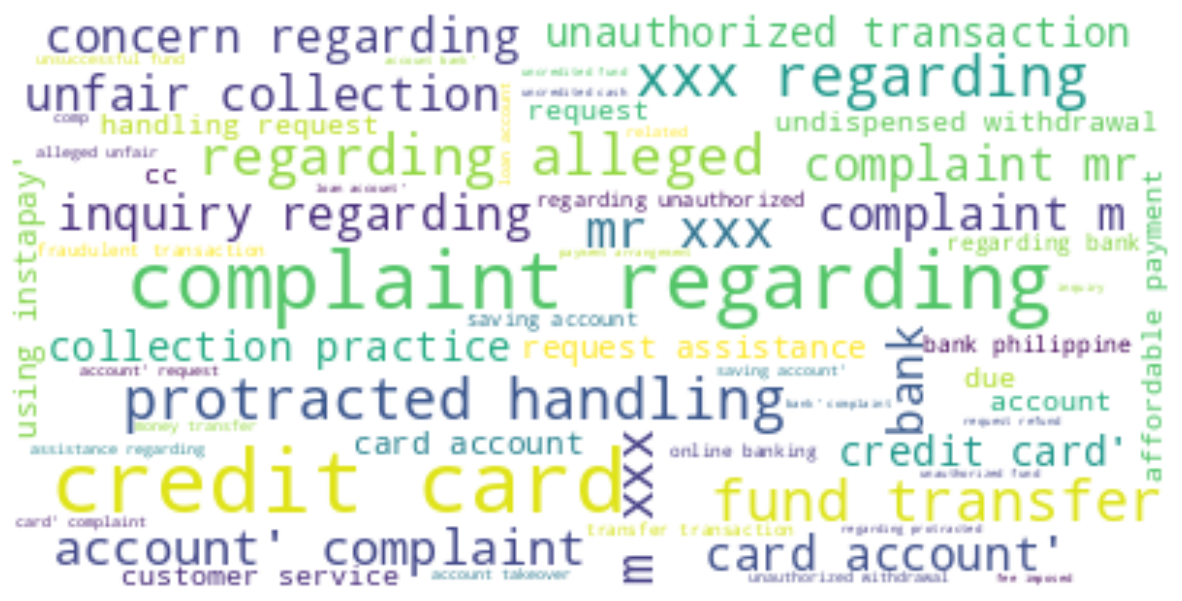

In [41]:
# wordcloud biagram plot

from collections import Counter
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=30, 
                      max_words=60, 
                      background_color="white", 
                      random_state=100).generate(str(Counter(proto_df1_clean['Complaint_clean'])))
plt.figure(figsize=[15,8])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

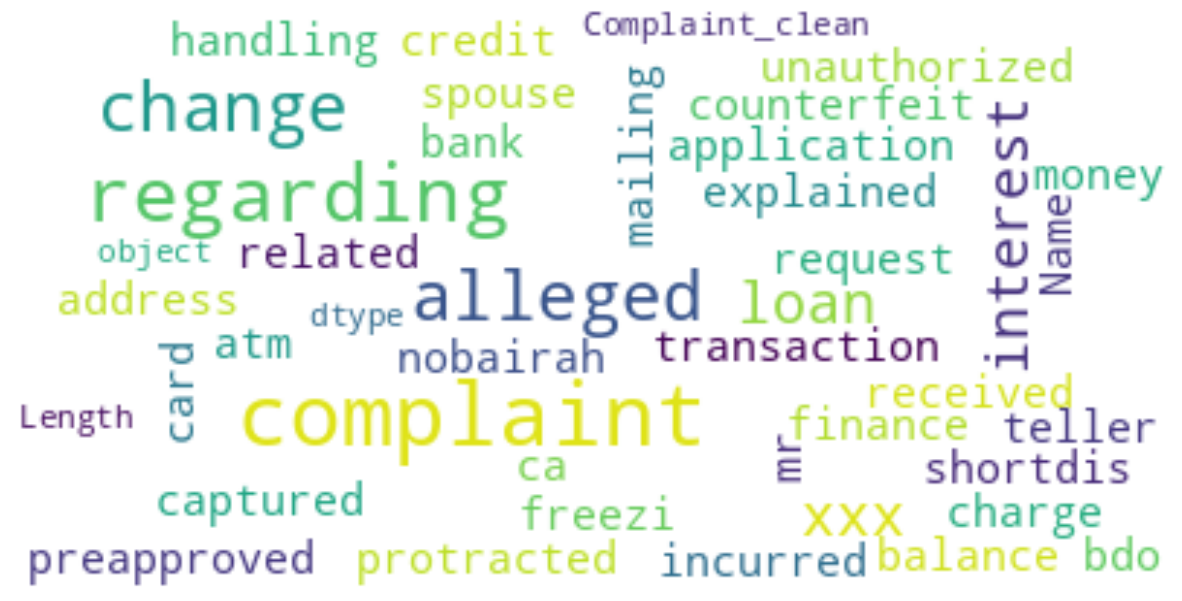

In [42]:
#wordcloud unigram plot

from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=30, 
                      max_words=60, 
                      background_color="white", 
                      random_state=100).generate(str(proto_df1_clean['Complaint_clean']))
plt.figure(figsize=[15,8])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

# Creating a function to extract top ngrams(unigram/bigram/trigram) based on the function inputs

def top_ngrams(text,n=None, n_grams=(1,1)):
    rev_model = CountVectorizer(ngram_range=n_grams).fit(text)
    rev_df = rev_model.fit_transform(text)
    
    sum_words = rev_df.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word,idx in rev_model.vocabulary_.items()]
    word_freq = sorted(word_freq, key= lambda x : x[1], reverse= True)
    return word_freq[:n]

In [44]:
#Unigram (top 20)

n=20
unigram_top20 = top_ngrams(proto_df1_clean['Complaint_clean'],n=n)
unigram_top20_data = pd.DataFrame(unigram_top20, columns = ['Unigram', 'Count'])
unigram_top20_data

,Unigram,Count
0,account,3592
1,regarding,3358
2,complaint,2771
3,card,2541
4,transaction,2032
5,credit,2013
6,bank,1833
7,request,1762
8,payment,1438
9,unauthorized,1406


In [45]:
#bigram (top 20)

n=20
n_grams = (2,2)

bigram_top20 = top_ngrams(proto_df1_clean['Complaint_clean'],n=n, n_grams=n_grams)
bigram_top20_data = pd.DataFrame(bigram_top20, columns = ['Bigram', 'Count'])
bigram_top20_data

,Bigram,Count
0,credit card,1871
1,complaint regarding,1354
2,fund transfer,600
3,card account,567
4,protracted handling,553
5,xxx regarding,507
6,regarding alleged,478
7,unauthorized transaction,395
8,collection practice,384
9,mr xxx,383


In [46]:
#trigram (top 20)

n=20
n_grams = (3,3)

trigram_top20 = top_ngrams(proto_df1_clean['Complaint_clean'],n=n, n_grams=n_grams)
trigram_top20_data = pd.DataFrame(trigram_top20, columns = ['Trigram', 'Count'])
trigram_top20_data

,Trigram,Count
0,credit card account,533
1,unfair collection practice,377
2,complaint mr xxx,275
3,mr xxx regarding,237
4,complaint regarding alleged,211
5,complaint xxx regarding,207
6,protracted handling request,185
7,fund transfer transaction,181
8,affordable payment arrangement,179
9,unsuccessful fund transfer,163


In [47]:
#Applying TFIDF vectorizer 

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(min_df = 2, max_df = 0.95)

tfidf_df = tfidf_model.fit_transform(proto_df1_clean['Complaint_clean'])
tfidf_df

<12657x2443 sparse matrix of type '<class 'numpy.float64'>'
	with 85698 stored elements in Compressed Sparse Row format>

In [48]:
#lda model 
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=5,
                                      learning_method='online',
                                      max_iter=20,
                                      random_state=42)

In [49]:
X_topics = lda_model.fit_transform(tfidf_df)

In [50]:
n_top_words = 15
topic_summaries = []

topic_word = lda_model.components_  # get the topic words (15)

In [53]:
vocab = tfidf_model.get_feature_names_out()

In [54]:
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: fee | undispensed | atm | regarding | withdrawal | inquiry | complaint | annual | check | card | bank | charged | imposed | deduction | terminal
Topic 1: transfer | fund | uncredited | using | cash | transaction | unsuccessful | gxi | gcash | instapay | money | account | acct | bdo | bpi
Topic 2: request | regarding | handling | card | complaint | protracted | credit | collection | refund | account | practice | unfair | payment | alleged | bank
Topic 3: loan | payment | bank | obligation | application | interest | regarding | alleged | settlement | complaint | request | credit | bill | auto | account
Topic 4: unauthorized | transaction | account | card | credit | online | saving | complaint | fraudulent | withdrawal | regarding | disputed | banking | arrangement | debit


In [55]:
no_topics = 5
words = np.array(vocab)
topic_words = pd.DataFrame(np.zeros((no_topics, 15)), index=[f'Topic {i + 1}' for i in range(no_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(no_topics):
    ix = topic_word[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,fee,undispensed,atm,regarding,withdrawal,inquiry,complaint,annual,check,card,bank,charged,imposed,deduction,terminal
Topic 2,transfer,fund,uncredited,using,cash,transaction,unsuccessful,gxi,gcash,instapay,money,account,acct,bdo,bpi
Topic 3,request,regarding,handling,card,complaint,protracted,credit,collection,refund,account,practice,unfair,payment,alleged,bank
Topic 4,loan,payment,bank,obligation,application,interest,regarding,alleged,settlement,complaint,request,credit,bill,auto,account
Topic 5,unauthorized,transaction,account,card,credit,online,saving,complaint,fraudulent,withdrawal,regarding,disputed,banking,arrangement,debit


In [56]:
topic_results = lda_model.transform(tfidf_df)

#assigning best results to the topics 
proto_df1_clean['Topic'] = topic_results.argmax(axis=1)
proto_df1_clean

,Complaint,Product,Complaint_clean,Topic
0,Your request to change your mailing address,CREDIT CARD,request change mailing address,1
1,unauthorized transactions on a pre-approved cr...,CREDIT CARD,unauthorized transaction preapproved credit ca...,1
2,Complaint of Mr. XXX regarding his applicatio...,CREDIT CARD,complaint mr xxx regarding application balance...,3
3,Captured ATM card,E-BANKING,captured atm card,0
4,Complaint of Spouses Nobairah and XXX regardin...,DEPOSIT,complaint spouse nobairah xxx regarding freezi...,2
...,...,...,...,...
12916,Complaint regarding alleged change in loan int...,CREDIT CARD,complaint regarding alleged change loan interest,3
12917,Complaint regarding alleged change in loan int...,LENDING,complaint regarding alleged change loan interest,3
12918,protracted handling of complaint related to sh...,E-BANKING,protracted handling complaint related shortdis...,2
12919,finance charges incurred which cannot be expla...,CREDIT CARD,finance charge incurred can not explained bank...,2


In [57]:
# Topic results - value counts
proto_df1_clean['Topic'].value_counts()

Topic
2    3498
3    2567
4    2437
1    2223
0    1932
Name: count, dtype: int64

In [58]:
#Print the first five complaints for each of the topics
proto_df1_clean_sort=proto_df1_clean.groupby('Topic').head(5)
proto_df1_clean_sort.sort_values('Topic')

,Complaint,Product,Complaint_clean,Topic
3,Captured ATM card,E-BANKING,captured atm card,0
5,fraudulent use of credit card account (Shopee)\n,CREDIT CARD,fraudulent use credit card account shopee,0
14,Double deduction of a purchase transaction on ...,E-BANKING,double deduction purchase transaction debit ca...,0
11,Concern on the documents received allegedly is...,OTHERS,concern document received allegedly issued hsb...,0
23,Complaint of Ms. XXX regarding the Medi Shield...,CREDIT CARD,complaint m xxx regarding medi shield plus cha...,0
1,unauthorized transactions on a pre-approved cr...,CREDIT CARD,unauthorized transaction preapproved credit ca...,1
0,Your request to change your mailing address,CREDIT CARD,request change mailing address,1
10,Complaint regarding unsuccessful money transac...,E-MONEY,complaint regarding unsuccessful money transac...,1
40,Complaint against an employee of the bank for ...,OTHERS,complaint employee bank alleged breach data pr...,1
61,Concern on possible phishing related to loan a...,LENDING,concern possible phishing related loan applica...,1


In [59]:
#Create the dictionary of topic names and topics; considered the following topic names based upon the topic words

Topic_names = { 0:"Bank account services", 1:"Transaction issues", 2: "Customer service",
               3:"Loan services", 4:"Theft/dispute reporting" }
#Replace Topics with Topic Names
proto_df1_clean['Topic'] = proto_df1_clean['Topic'].map(Topic_names)
proto_df1_clean

,Complaint,Product,Complaint_clean,Topic
0,Your request to change your mailing address,CREDIT CARD,request change mailing address,Transaction issues
1,unauthorized transactions on a pre-approved cr...,CREDIT CARD,unauthorized transaction preapproved credit ca...,Transaction issues
2,Complaint of Mr. XXX regarding his applicatio...,CREDIT CARD,complaint mr xxx regarding application balance...,Loan services
3,Captured ATM card,E-BANKING,captured atm card,Bank account services
4,Complaint of Spouses Nobairah and XXX regardin...,DEPOSIT,complaint spouse nobairah xxx regarding freezi...,Customer service
...,...,...,...,...
12916,Complaint regarding alleged change in loan int...,CREDIT CARD,complaint regarding alleged change loan interest,Loan services
12917,Complaint regarding alleged change in loan int...,LENDING,complaint regarding alleged change loan interest,Loan services
12918,protracted handling of complaint related to sh...,E-BANKING,protracted handling complaint related shortdis...,Customer service
12919,finance charges incurred which cannot be expla...,CREDIT CARD,finance charge incurred can not explained bank...,Customer service


In [60]:
proto_df1_clean['Product'].value_counts()

Product
CREDIT CARD                                 3461
E-BANKING                                   2223
LENDING                                     1925
E-MONEY                                     1586
DEPOSIT                                     1532
OTHERS                                      1444
PAWNSHOP/REMITTANCE AGENTS/MONEY CHANGER     337
INVESTMENT                                    60
INSURANCE                                     60
FOREX                                         25
VIRTUAL CURRENCY                               4
Name: count, dtype: int64

In [61]:
proto_df1_clean['Topic'].value_counts()

Topic
Customer service           3498
Loan services              2567
Theft/dispute reporting    2437
Transaction issues         2223
Bank account services      1932
Name: count, dtype: int64

In [62]:
# Create a new dataframe with the required columns
data = proto_df1_clean[['Complaint', 'Topic']]
data 

,Complaint,Topic
0,Your request to change your mailing address,Transaction issues
1,unauthorized transactions on a pre-approved cr...,Transaction issues
2,Complaint of Mr. XXX regarding his applicatio...,Loan services
3,Captured ATM card,Bank account services
4,Complaint of Spouses Nobairah and XXX regardin...,Customer service
...,...,...
12916,Complaint regarding alleged change in loan int...,Loan services
12917,Complaint regarding alleged change in loan int...,Loan services
12918,protracted handling of complaint related to sh...,Customer service
12919,finance charges incurred which cannot be expla...,Customer service


In [63]:
Topic_names1 = {"Bank account services": 0, "Transaction issues": 1, "Customer service": 2,
                "Loan services": 3, "Theft/dispute reporting": 4}
#Replace Topics with Topic Names
data['Topic'] = data['Topic'].map(Topic_names1)
#Convert from float to int datatype
data['Topic'] = data['Topic'].astype(int)

In [64]:
data

,Complaint,Topic
0,Your request to change your mailing address,1
1,unauthorized transactions on a pre-approved cr...,1
2,Complaint of Mr. XXX regarding his applicatio...,3
3,Captured ATM card,0
4,Complaint of Spouses Nobairah and XXX regardin...,2
...,...,...
12916,Complaint regarding alleged change in loan int...,3
12917,Complaint regarding alleged change in loan int...,3
12918,protracted handling of complaint related to sh...,2
12919,finance charges incurred which cannot be expla...,2


In [65]:
# Converting text data to numeric format using tfidf and countvectoriser 

# 1. Countvectoriser

count_model1 = CountVectorizer()
data_cv = count_model1.fit_transform(data['Complaint'])

In [66]:
# 2. tfidf vectoriser

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_trasformer = TfidfTransformer()
data_tfidf = tfidf_trasformer.fit_transform(data_cv)

tfidf_model1 = TfidfVectorizer()
tfidf_vect = tfidf_model1.fit_transform(data['Complaint'])

In [67]:
# split the data

x= tfidf_vect
y= data['Topic']

print(y.head())

0    1
1    1
2    3
3    0
4    2
Name: Topic, dtype: int64


In [68]:
#split the data into train and test sets

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size= 0.2, random_state= 42)

In [69]:
ytrain.value_counts()

Topic
2    2809
3    2024
4    1956
1    1786
0    1550
Name: count, dtype: int64

In [70]:
ytest.value_counts()

Topic
2    689
3    543
4    481
1    437
0    382
Name: count, dtype: int64

### Model Development - Decision Tree/Random Forest/XGBoost

In [71]:
# Model 1: Decision tree 

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


DT = DecisionTreeClassifier(criterion= 'entropy')

param = {'min_samples_leaf' : list(range(1,9)),
        'max_depth' : list(range(1,9)),
        'max_features' : ['sqrt']}

grid_search = GridSearchCV(estimator= DT,
                          param_grid= param,
                          n_jobs= -1,
                          scoring= 'accuracy',
                          cv= 5,
                          refit= True,
                          return_train_score= True)

grid_search.fit(xtrain,ytrain)
grid_search.best_params_

{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 6}

In [72]:
estimator = grid_search.best_estimator_

from sklearn.metrics import accuracy_score, confusion_matrix

print('confusion metrix :',
     confusion_matrix(ytrain, estimator.predict(xtrain)))
print('accuracy score :', accuracy_score(ytrain, estimator.predict(xtrain)))

confusion metrix : [[  48   40 1413   38   11]
 [   5  618 1119   17   27]
 [  15   56 2643   57   38]
 [   7   45 1812  125   35]
 [  13   44 1598   28  273]]
accuracy score : 0.3661234567901235


In [73]:
print('confusion metrix :', confusion_matrix(ytest, estimator.predict(xtest)))
print('accuracy score :',accuracy_score(ytest, estimator.predict(xtest)))

confusion metrix : [[ 10  13 344   8   7]
 [  1 145 280   4   7]
 [  6  20 645  11   7]
 [  1   9 487  39   7]
 [  4  12 398   6  61]]
accuracy score : 0.35545023696682465


In [74]:
# Model 2: Random Forest 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param1 = {'min_samples_leaf' : list(range(1,9)),
        'max_depth' : list(range(1,9)),
        'max_features' : ['sqrt']}

grid_search1 = GridSearchCV(estimator= rf,
                           param_grid= param1,
                           cv= 5,
                           n_jobs= -1,
                           scoring= 'accuracy',
                           refit= True,
                           return_train_score= True)

grid_search1.fit(xtrain, ytrain)
grid_search1.best_params_

{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4}

In [75]:
estimator1 = grid_search1.best_estimator_

print('confusion matrix :',
     confusion_matrix(ytrain, estimator1.predict(xtrain)))

print('accuracy score :', accuracy_score(ytrain, estimator1.predict(xtrain)))

confusion matrix : [[ 182   19 1274   31   44]
 [   5  947  757   21   56]
 [   1   39 2719   22   28]
 [   2   30 1457  505   30]
 [   9   63 1070   18  796]]
accuracy score : 0.5085432098765432


In [76]:
print('confusion matrix :',
     confusion_matrix(ytest, estimator1.predict(xtest)))

print('accuracy score :', accuracy_score(ytest, estimator1.predict(xtest)))

confusion matrix : [[ 45   3 318  11   5]
 [  2 220 195   6  14]
 [  0  12 666   5   6]
 [  1   8 422 104   8]
 [  3  18 288   2 170]]
accuracy score : 0.4759083728278041


In [77]:
# Model 3 - XGBoost
xgb = XGBClassifier(num_class = 2,
                    objective="multi:softprob",
                    eval_metric="mlogloss",
                    seed=42) 

In [78]:
xgb.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=2, num_parallel_tree=None, ...)

In [79]:
xgbpred=xgb.predict(xtest)

0.745260663507109
Confusion matrix


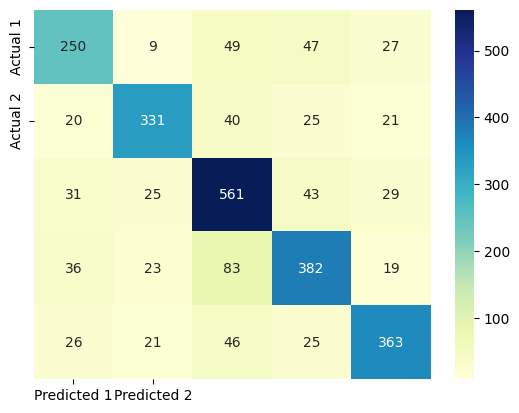

Classification report
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       382
           1       0.81      0.76      0.78       437
           2       0.72      0.81      0.76       689
           3       0.73      0.70      0.72       543
           4       0.79      0.75      0.77       481

    accuracy                           0.75      2532
   macro avg       0.75      0.74      0.74      2532
weighted avg       0.75      0.75      0.74      2532



In [80]:
print(metrics.accuracy_score(ytest,xgbpred))
print('Confusion matrix')
xgb_cm=metrics.confusion_matrix(ytest, xgbpred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(xgb_cm, annot=True,cmap='YlGnBu', fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('Classification report')
print(metrics.classification_report(ytest,xgbpred))

In [ ]:
#Hyper parameter tuning - GridSearch

xgb_gs = XGBClassifier(num_class = 2,
                           objective="multi:softprob",
                           seed=42)                         
                        
param_grid = {"max_depth": [10,15,20],
              "n_estimators": range(5,20,5), 
              "gamma": [0.03,0.05], 
              "learning_rate": [0.01,0.05]}


grid_search = GridSearchCV(xgb_gs, 
                           param_grid=param_grid,
                           cv = 5,
                           n_jobs=-1,
                           scoring='neg_log_loss',
                           verbose=2)
grid_search.fit(xtrain,ytrain)
grid_search.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sk

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sk

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sk

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sk

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sk

[16:47:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 15}

In [223]:
xgb_ypred=grid_search.predict(xtest)  

0.6714060031595577
Confusion matrix


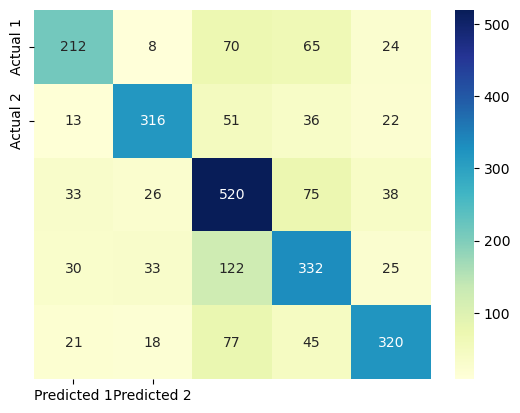

Classification report
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       379
           1       0.79      0.72      0.75       438
           2       0.62      0.75      0.68       692
           3       0.60      0.61      0.61       542
           4       0.75      0.67      0.70       481

    accuracy                           0.67      2532
   macro avg       0.69      0.66      0.67      2532
weighted avg       0.68      0.67      0.67      2532



In [224]:
print(metrics.accuracy_score(ytest,xgb_ypred))

print('Confusion matrix')
xgb_cfm=metrics.confusion_matrix(ytest, xgb_ypred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(xgb_cfm, annot=True, cmap="YlGnBu", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('Classification report')
print(metrics.classification_report(ytest,xgb_ypred))

In [225]:
# XGBoost - Best accuracy for the model at ~74%. Grid Search for XGBoost did not lead to accuracy improvement. 
# Overall, this is a good classification model. 